julia 1.8.2 (might be under jupyter kernels)

## SETUP

not entirely sure if this needs to be run each time, but I've been doing it

In [2]:
# Expand the path to include all Conda binary locations
conda_env = "C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline"
new_paths = [
    joinpath(conda_env, "bin"),
    joinpath(conda_env, "Library", "bin"),
    joinpath(conda_env, "Scripts")
]
ENV["PATH"] = join(new_paths, ";") * ";" * ENV["PATH"]

using PyCall
# Re-verify PyCall is definitely looking at the right python
println("PyCall using: ", PyCall.python) 

torch = pyimport("torch")

PyCall using: C:\Users\munib\miniconda3\envs\nir-pipeline\python.exe


PyObject <module 'torch' from 'C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\lib\\site-packages\\torch\\__init__.py'>

In [3]:
using Pkg
ENV["PYTHON"] = "C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\python.exe"
Pkg.build("PyCall")

    Building Conda ─→ `C:\Users\munib\.julia-flv\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\8f06b0cfa4c514c7b9546756dbae91fcfbc92dc9\build.log`
    Building PyCall → `C:\Users\munib\.julia-flv\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`


In [4]:
using PyCall
PyCall.python
# make sure this is the correct path to your conda environment's python, which should have all the necessary packages installed.

"C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\python.exe"

In [5]:
torch = pyimport("torch")

println("Is CUDA available? ", torch.cuda.is_available())
println("GPU Name: ", torch.cuda.get_device_name(0))

Is CUDA available? true
GPU Name: NVIDIA GeForce RTX 5080


## CONFIG

In [6]:
# using CUDA
# # CUDA.set_runtime_version!(v"12.0"; local_toolkit=false)
# CUDA.runtime_version()

In [7]:
# --- GPU setup (set to "" to disable GPU) ---
ENV["CUDA_VISIBLE_DEVICES"] = "0"   # Use GPU 0; set to "" for CPU
ENV["JULIA_IO_BUFFER"] = "0"

# --- Load packages ---
using ImageDataIO, BehaviorDataNIR, UNet2D, H5Zblosc
using HDF5, PyPlot, FileIO

┌ Warning: CUDA runtime library cudart64_12.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\munib\.julia-flv\packages\CUDA\rXson\src\initialization.jl:189
┌ Warning: CUDA runtime library caffe2_nvrtc.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\munib\.julia-flv\packages\CUDA\rXson\src\initialization.jl:189
┌ Warning: CUDA runtime library nvrtc64_120_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\munib\.julia-flv\packages\CUDA\rXson\src\initialization.jl:189
┌ Warning: CUDA runtime library cublas64_12.dll was loaded from a syst

In [8]:
# Check if the globals were actually initialized
println("py_ski_morphology: ", BehaviorDataNIR.py_ski_morphology)
println("py_skl_neighbors: ", BehaviorDataNIR.py_skl_neighbors)
println("py_nx: ", BehaviorDataNIR.py_nx)

py_ski_morphology: PyObject <module 'skimage.morphology' from 'C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\lib\\site-packages\\skimage\\morphology\\__init__.py'>
py_skl_neighbors: PyObject <module 'sklearn.neighbors' from 'C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\lib\\site-packages\\sklearn\\neighbors\\__init__.py'>
py_nx: PyObject <module 'networkx' from 'C:\\Users\\munib\\miniconda3\\envs\\nir-pipeline\\lib\\site-packages\\networkx\\__init__.py'>


In [9]:
# ============================================================
# USER CONFIG — EDIT THESE
# ============================================================
NAME = "date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004"  

# Windows paths:
PATH_H5   = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20260113\\$(NAME).h5"
PATH_JLD2 = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20260113\\$(NAME)_data_dict.jld2"

# Linux paths (if running on server):
# PATH_H5   = "/data3/albert/2024/$(NAME).h5"
# PATH_JLD2 = "/home/user/data/$(NAME)_data_dict.jld2"

# Path to segmentation model weights
# (copy worm_segmentation_best_weights_0310.pt to a known location)
path_weight = "C:\\Users\\munib\\POSTDOC\\CODE\\g5ht-pipeline\\nir\\worm_segmentation_best_weights_0310.pt"

"C:\\Users\\munib\\POSTDOC\\CODE\\g5ht-pipeline\\nir\\worm_segmentation_best_weights_0310.pt"

In [10]:
# ============================================================
# GET FRAME COUNT
# ============================================================
# Simple approach:
MAX_T_NIR = size(h5open(PATH_H5)["img_nir"])[3]

# Safer approach — finds last readable frame (use if h5 file is truncated):
# function last_good_frame(PATH_H5)
#     out = 0
#     for i = 1:size(h5open(PATH_H5)["img_nir"])[3]
#         try
#             img = h5open(PATH_H5)["img_nir"][:, :, i]
#         catch
#             break
#         end
#         out = i
#     end
#     return out
# end
# MAX_T_NIR = last_good_frame(PATH_H5)

println("Total NIR frames: $MAX_T_NIR")

Total NIR frames: 9432


In [11]:
# ============================================================
# CREATE `param` DICTIONARY
# ============================================================
# These are the algorithm parameters — usually no need to change
param = Dict()

# --- For 1st compute_worm_spline!() ---
param["num_center_pts"]           = 1000    # Number of points along the spline
param["img_label_size"]           = (480, 360)  # Expected NIR image size
param["nose_confidence_threshold"] = 0.99   # UNet confidence for nose detection
param["nose_crop_threshold"]      = 20      # Crop threshold for nose region

# --- For compute_worm_thickness() ---
param["min_len_percent"]          = 90      # Min worm length percentile
param["max_len_percent"]          = 98      # Max worm length percentile

# --- For 2nd compute_worm_spline!() (after thickness detection) ---
param["worm_thickness_pad"]       = 3       # Padding around worm thickness
param["boundary_thickness"]       = 5       # Boundary thickness for detection
param["close_pts_threshold"]      = 30      # Threshold for close points
param["trim_head_tail"]           = 15      # Trim head/tail pixels
param["max_med_axis_delta"]       = Inf     # Max medial axis displacement

Inf

In [12]:
# ============================================================
# CREATE `data_dict` DICTIONARY
# ============================================================
# This is the main output dictionary. Here are ALL the keys
# and what they store:

data_dict = Dict()

# --- Medial axis results (Dict of per-frame data) ---
data_dict["med_axis_dict"] = Dict()       # Medial axis points per frame
data_dict["med_axis_dict"][0] = nothing    # Initialize with sentinel

# --- Point ordering (Dict of per-frame data) ---
data_dict["pts_order_dict"] = Dict()      # Ordered skeleton points per frame
data_dict["pts_order_dict"][0] = nothing   # Initialize with sentinel

# --- Omega turn detection (Dict of Bool per frame) ---
data_dict["is_omega"] = Dict()            # Whether frame has omega turn

# --- Spline coordinates: (n_frames, num_center_pts+1) matrices ---
data_dict["x_array"] = zeros(MAX_T_NIR, param["num_center_pts"] + 1)
data_dict["y_array"] = zeros(MAX_T_NIR, param["num_center_pts"] + 1)

# --- Per-frame scalar metrics ---
data_dict["nir_worm_angle"] = zeros(MAX_T_NIR)  # Worm body angle per frame
data_dict["eccentricity"]   = zeros(MAX_T_NIR)  # Worm eccentricity per frame

# --- Error tracking ---
error_dict = Dict()

Dict{Any, Any}()

## Computing the Worm Spline (Julia)

The spline computation runs in **Julia** using the Flavell lab's `BehaviorDataNIR.jl` package. It:
1. Segments the worm from each NIR frame using a UNet2D model
2. Computes the medial axis (skeleton) of the worm
3. Fits a smooth spline along the medial axis
4. Detects omega turns and self-intersections
5. Recomputes a cleaned spline

### MAIN

In [13]:

# Stage 1: Load the UNet2D segmentation model
println("Loading model...")
using PyCall
# Define the CPU device using PyCall to talk to torch
# device = pyimport("torch").device("cpu")
# worm_seg_model = create_model(1, 1, 16, path_weight, device=device)
worm_seg_model = create_model(1, 1, 16, path_weight)
println("Model loaded successfully.")

Loading model...
Model loaded successfully.


Loading model...
Model loaded successfully.
Computing initial spline (pass 1)...
Detecting self-intersection...
Recomputing spline (pass 2)...
Saving data_dict to: C:\Users\munib\POSTDOC\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004_data_dict.jld2
Done!


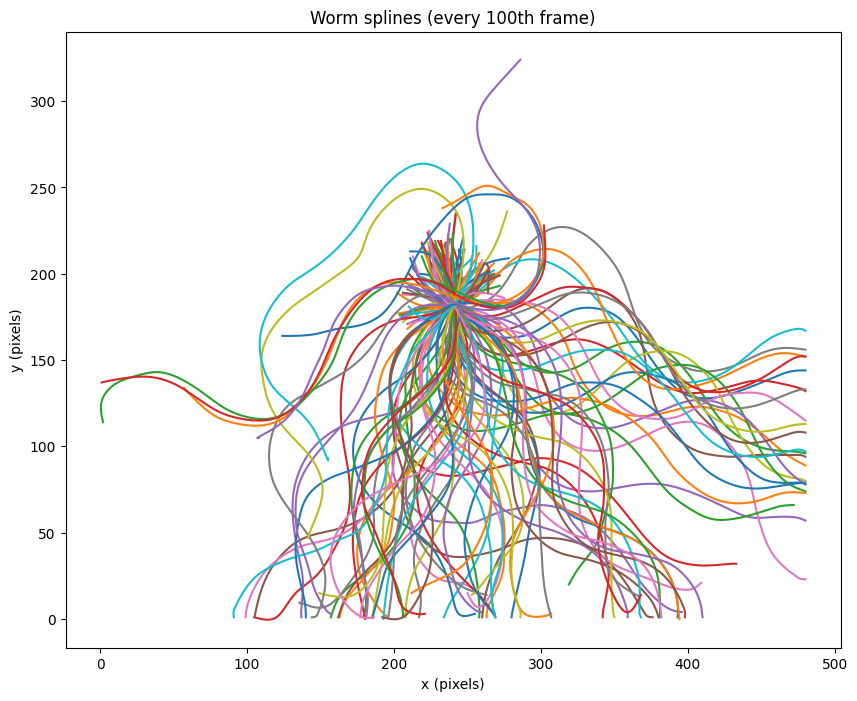

PyObject Text(24.000000000000007, 0.5, 'y (pixels)')

In [14]:
# ============================================================
# RUN SPLINE COMPUTATION (3 stages) , takes around 5 hours total
# ============================================================

# Stage 1: Load the UNet2D segmentation model
println("Loading model...")
using PyCall
# Define the CPU device using PyCall to talk to torch
# device = pyimport("torch").device("cpu")
# worm_seg_model = create_model(1, 1, 16, path_weight, device=device)
worm_seg_model = create_model(1, 1, 16, path_weight)
println("Model loaded successfully.")

# Stage 2: Initial spline computation, around 200 minutes
println("Computing initial spline (pass 1)...")
error_dict["worm_spline_errors_1"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, nothing,
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"]
)

# Stage 3: Detect self-intersections using worm thickness (quick)
println("Detecting self-intersection...")
data_dict["worm_thickness"], count = compute_worm_thickness(
    param, PATH_H5, worm_seg_model,
    data_dict["med_axis_dict"], data_dict["is_omega"]
)

# Stage 4: Recompute spline with thickness correction (takes around 90 mins)
println("Recomputing spline (pass 2)...")
error_dict["worm_spline_errors_2"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, data_dict["worm_thickness"],
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"],
    timepts=1:MAX_T_NIR
)

# ============================================================
# SAVE RESULTS
# ============================================================
println("Saving data_dict to: $PATH_JLD2")
save(PATH_JLD2, "data_dict", data_dict)
println("Done!")

# Quick sanity check — plot every 100th frame's spline
using PyPlot
figure(figsize=(10, 8))
step = 100
for i = 1:step:MAX_T_NIR
    plot(data_dict["x_array"][i, :], data_dict["y_array"][i, :])
end
title("Worm splines (every $(step)th frame)")
xlabel("x (pixels)")
ylabel("y (pixels)")
# savefig("spline_check.png", dpi=150)

In [ ]:
# # find the path to the compute_worm_spline!() function
# @which compute_worm_spline!(
#     param, PATH_H5, worm_seg_model, nothing,
#     data_dict["med_axis_dict"], data_dict["pts_order_dict"],
#     data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
#     data_dict["nir_worm_angle"], data_dict["eccentricity"],
#     timepts=1:MAX_T_NIR
# )

In [ ]:
# Stage 2: Initial spline computation, around 200 minutes
println("Computing initial spline (pass 1)...")
error_dict["worm_spline_errors_1"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, nothing,
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"]
)

In [ ]:
error_dict["worm_spline_errors_1"][4986]

#### Diagnostic: run a single failing frame WITHOUT try/catch to get the full stack trace

In [ ]:
# ============================================================
# DIAGNOSTIC: Run one failing frame WITHOUT try/catch
# Change `test_idx` to any frame that appeared in the error dict
# ============================================================
test_idx = 1  # start with frame 1 (uses sentinel nothing values from key 0)

# --- Reproduce the exact setup compute_worm_spline! does ---
spline_interval = 1/param["num_center_pts"]
img_label_test = zeros(Int32, param["img_label_size"][1], param["img_label_size"][2])

f = h5open(PATH_H5)
pos_feature, pos_feature_unet = BehaviorDataNIR.read_pos_feature(f)
close(f)

println("pos_feature_unet size: ", size(pos_feature_unet))

pts = pos_feature_unet[:,:,test_idx]
pts_n = pts[1, :]
pts_n[3] = minimum(pts[:,3])
println("pts_n: ", pts_n)

f = h5open(PATH_H5)
img_raw = f["img_nir"][:,:,test_idx]
close(f)
println("img_raw size: ", size(img_raw), " type: ", typeof(img_raw))

# Step 1: Segment
println("\n--- Step 1: segment_worm! ---")
img_raw_ds, img_bin = BehaviorDataNIR.segment_worm!(worm_seg_model, img_raw, img_label_test)
println("segment_worm! succeeded. img_bin type: ", typeof(img_bin), " size: ", size(img_bin))

img_bin = Int32.(img_bin)

# Step 2: Medial axis (this is likely where it fails)
println("\n--- Step 2: medial_axis ---")
med_xs, med_ys, pts_order, is_omega = BehaviorDataNIR.medial_axis(
    param, img_bin, pts_n,
    prev_med_axis=data_dict["med_axis_dict"][test_idx-1],
    prev_pts_order=data_dict["pts_order_dict"][test_idx-1],
    worm_thickness=nothing
)
println("medial_axis succeeded! is_omega=$is_omega, n_pts=$(length(med_xs))")

# Step 3: Fit spline
println("\n--- Step 3: fit_spline ---")
spl_data, spl = BehaviorDataNIR.fit_spline(param, med_xs, med_ys, pts_n, n_subsample=15)
spl_pts = spl(0:spline_interval:1, 1:2)
println("fit_spline succeeded! spl_pts size: ", size(spl_pts))

println("\n=== All steps passed for frame $test_idx ===")

In [ ]:
# Stage 3: Detect self-intersections using worm thickness (quick)
println("Detecting self-intersection...")
data_dict["worm_thickness"], count = compute_worm_thickness(
    param, PATH_H5, worm_seg_model,
    data_dict["med_axis_dict"], data_dict["is_omega"]
)

In [ ]:
# Stage 4: Recompute spline with thickness correction (takes around 90 mins)
println("Recomputing spline (pass 2)...")
error_dict["worm_spline_errors_2"] = compute_worm_spline!(
    param, PATH_H5, worm_seg_model, data_dict["worm_thickness"],
    data_dict["med_axis_dict"], data_dict["pts_order_dict"],
    data_dict["is_omega"], data_dict["x_array"], data_dict["y_array"],
    data_dict["nir_worm_angle"], data_dict["eccentricity"],
    timepts=1:MAX_T_NIR
)

# ============================================================
# SAVE RESULTS
# ============================================================
println("Saving data_dict to: $PATH_JLD2")
save(PATH_JLD2, "data_dict", data_dict)
println("Done!")

In [ ]:
# Quick sanity check — plot every 100th frame's spline
using PyPlot
figure(figsize=(10, 8))
step = 100
for i = 1:step:MAX_T_NIR
    plot(data_dict["x_array"][i, :], data_dict["y_array"][i, :])
end
title("Worm splines (every $(step)th frame)")
xlabel("x (pixels)")
ylabel("y (pixels)")
# savefig("spline_check.png", dpi=150)

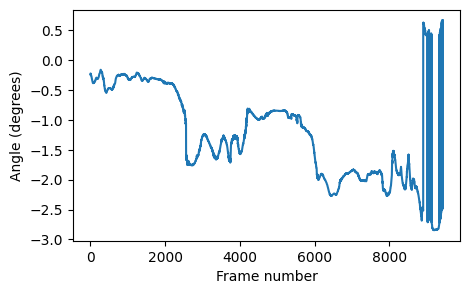

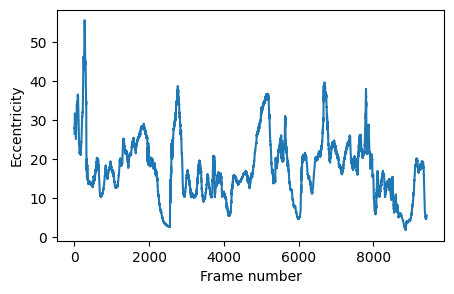

PyObject Text(24.0, 0.5, 'Eccentricity')

In [15]:
# plot worm angle
using PyPlot
figure(figsize=(5,3))
plot(1:MAX_T_NIR, data_dict["nir_worm_angle"])
xlabel("Frame number")
ylabel("Angle (degrees)")

# plot eccentricity
figure(figsize=(5,3))
plot(1:MAX_T_NIR, data_dict["eccentricity"])
xlabel("Frame number")
ylabel("Eccentricity")

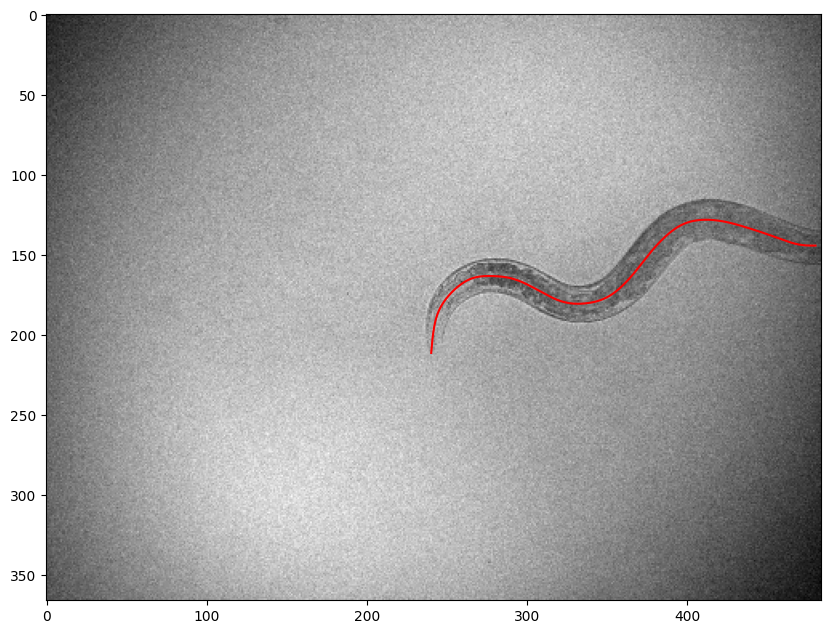

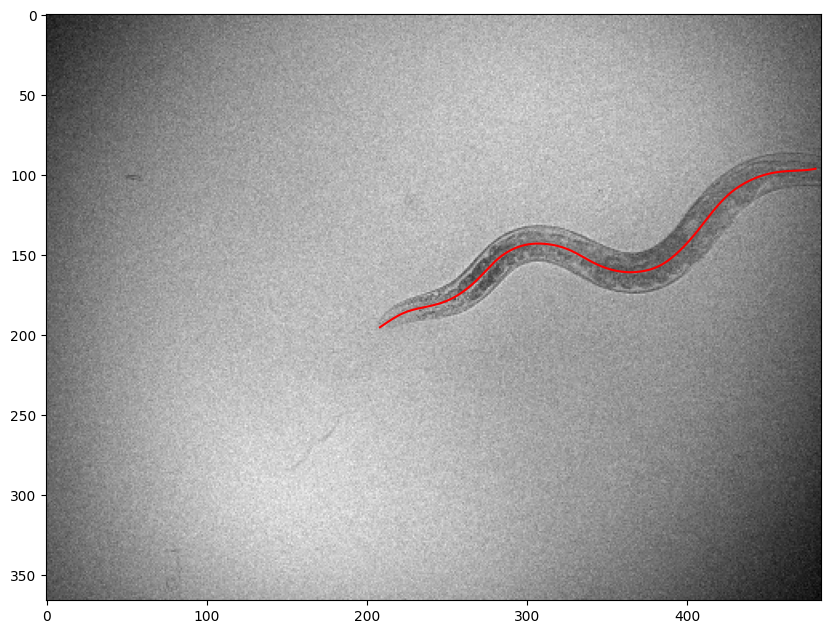

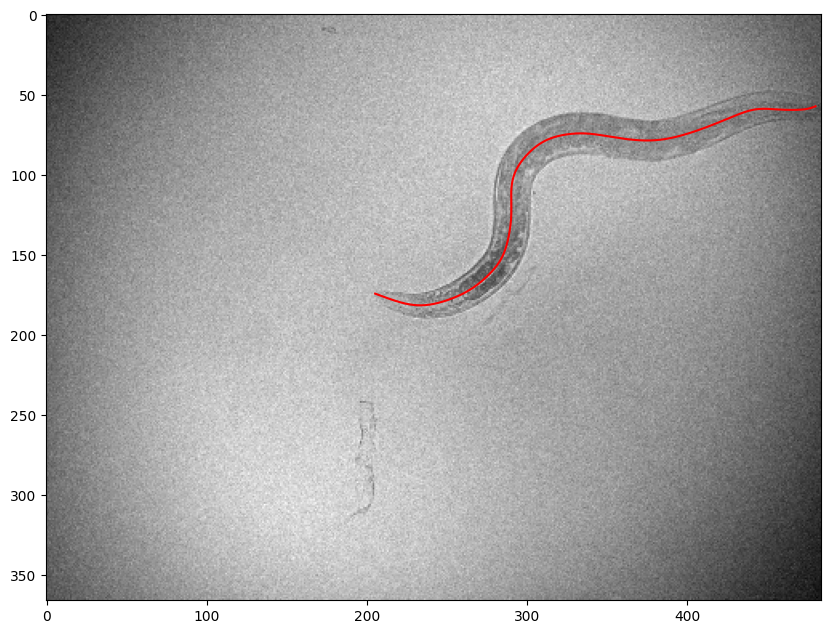

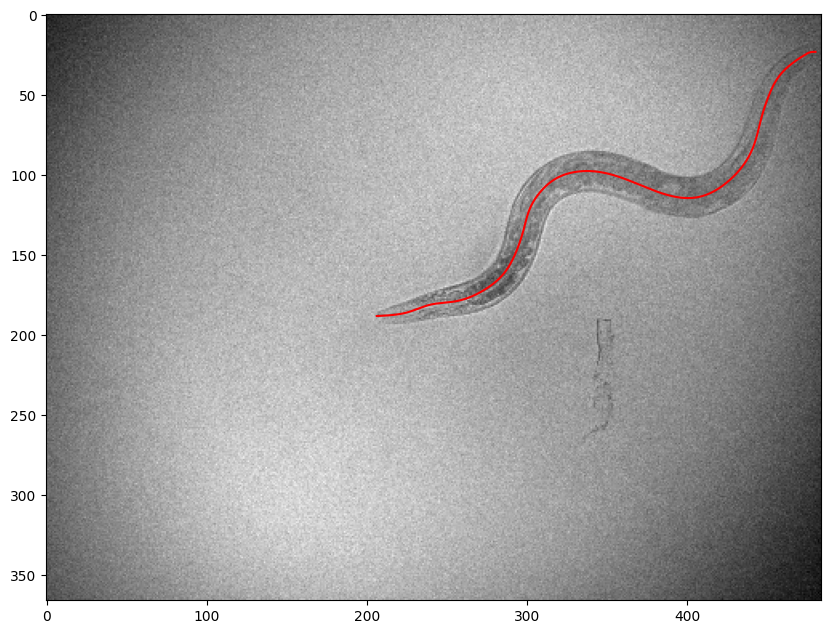

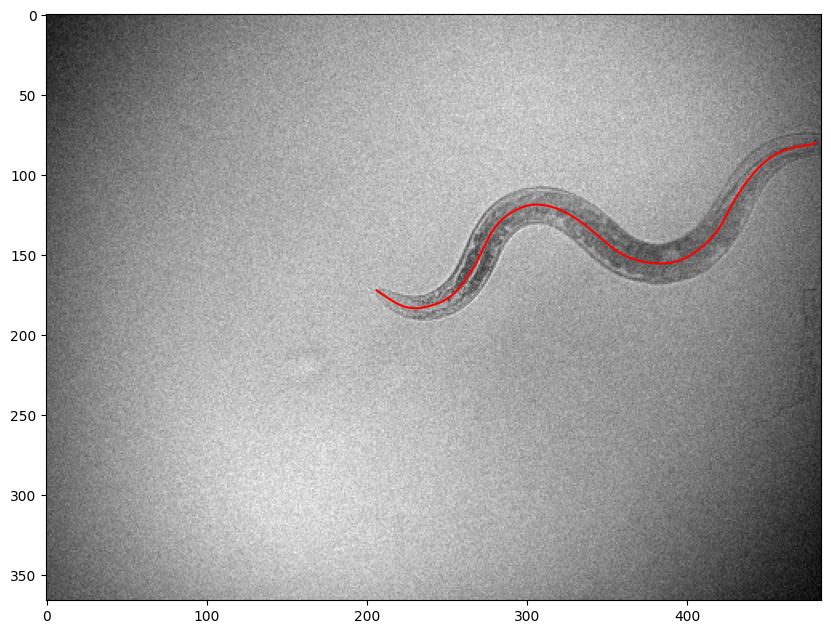

In [16]:
# plot frames overlaid with spline
# downsample the frame 2x for faster plotting
step=200
for i = 1:step:1000
    figure(figsize=(10, 8))
    f = h5open(PATH_H5)
    img_raw = f["img_nir"][:,:,i]
    # downsample img_raw by 2x
    img_raw = img_raw[1:2:end, 1:2:end]
    close(f)
    imshow(img_raw', cmap="gray")
    plot(data_dict["x_array"][i, :], data_dict["y_array"][i, :], color="red")
end

## `data_dict` Keys After Spline Computation

After running the spline script, the saved `.jld2` file contains:

| Key | Type | Shape | Description |
|-----|------|-------|-------------|
| `x_array` | `Matrix{Float64}` | `(MAX_T_NIR, 1001)` | X coords of spline points per frame |
| `y_array` | `Matrix{Float64}` | `(MAX_T_NIR, 1001)` | Y coords of spline points per frame |
| `nir_worm_angle` | `Vector{Float64}` | `(MAX_T_NIR,)` | Overall worm body angle per frame |
| `eccentricity` | `Vector{Float64}` | `(MAX_T_NIR,)` | Worm shape eccentricity per frame |
| `med_axis_dict` | `Dict` | per-frame | Medial axis points (raw skeleton) |
| `pts_order_dict` | `Dict` | per-frame | Ordered skeleton points |
| `is_omega` | `Dict{Int,Bool}` | per-frame | Whether frame shows omega turn |
| `worm_thickness` | value | scalar | Estimated worm thickness in pixels |

Now you have to run the python code in NIR_behavioral_pipeline_guide.ipynb. Then come back here and run the julia code below

# Computing Behavioral Metrics

After computing the spline (Part 4) and syncing timing, you can compute a full suite of behavioral metrics in Julia.

This uses `BehaviorDataNIR.jl` functions. Run this Julia code after you have a saved `data_dict.jld2`.

In [31]:
# ============================================================
# compute_behavior.jl — Full behavioral metrics
# ============================================================
# Run AFTER compute_spline.jl has produced a data_dict.jld2
# ============================================================

using HDF5, H5Zblosc, JLD2, BehaviorDataNIR, Statistics
include("nir_utils.jl")

# --- Config ---
NAME = "date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004"  
PATH_H5   = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20260113\\$(NAME).h5"
PATH_JLD2 = "C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20260113\\$(NAME)_data_dict.jld2"

# Auto-detect the number of laser on/off cycles per confocal volume.
# This replaces the old hardcoded CONFOCAL_STACK value (e.g. 441 or 11)
# by analyzing the gap pattern in the DAQ laser signal.
CONFOCAL_STACK = estimate_confocal_stack(PATH_H5)

# Load previously saved data_dict (from spline computation)
data_dict = load(PATH_JLD2, "data_dict")

# ============================================================
# STEP 1: Add non-spline data (stage position, sync, etc.)
# ============================================================
add_nonspline_data!(data_dict, PATH_H5; stack=CONFOCAL_STACK)

println("max_t = ", data_dict["max_t"], "  max_t_nir = ", data_dict["max_t_nir"])
println("length(confocal_to_nir) = ", length(data_dict["confocal_to_nir"]))
n_empty = count(t -> isempty(data_dict["confocal_to_nir"][t]), 1:length(data_dict["confocal_to_nir"]))
println("empty confocal_to_nir entries: $n_empty / $(length(data_dict["confocal_to_nir"]))")

# ============================================================
# STEP 2: Compute all behavioral metrics
# ============================================================
param = Dict()
param["num_center_pts"]    = 1000
param["segment_len"]       = 7
param["max_pt"]            = 31
param["body_angle_t_lag"]  = 40
param["body_angle_pos_lag"]= 2
param["head_pts"]          = [1, 5, 8]
param["filt_len_angvel"]   = 150
param["FLIR_FPS"]          = 20.0
param["v_stage_m_filt"]    = 10
param["v_stage_λ_filt"]    = 250.0
param["rev_len_thresh"]    = 2
param["rev_v_thresh"]      = -0.005
param["nose_pts"]          = [1, 2, 3]

vec_to_confocal = vec -> nir_vec_to_confocal(
    vec, data_dict["confocal_to_nir"], data_dict["max_t"]
)

interpolate_splines!(data_dict)

data_dict["segment_end_matrix"] = get_segment_end_matrix(
    param, data_dict["x_array"], data_dict["y_array"]
)

data_dict["x_stage_confocal"] = vec_to_confocal(data_dict["x_stage"])
data_dict["y_stage_confocal"] = vec_to_confocal(data_dict["y_stage"])

data_dict["zeroed_x"], data_dict["zeroed_y"] = zero_stage(
    data_dict["x_med"], data_dict["y_med"]
)
data_dict["zeroed_x_confocal"] = vec_to_confocal(data_dict["zeroed_x"])
data_dict["zeroed_y_confocal"] = vec_to_confocal(data_dict["zeroed_y"])

get_body_angles_safe!(data_dict, param)
get_angular_velocity_safe!(data_dict, param)
get_velocity_safe!(data_dict, param)
get_curvature_variables_safe!(data_dict, param)
get_nose_curling_safe!(data_dict, param)

save(PATH_JLD2, "data_dict", data_dict)
println("Behavioral metrics computed and saved!")

Auto-detected CONFOCAL_STACK:
  Total laser cycles:              369599
  Detected confocal volumes:       35417
  Cycles per volume (median):      6
  Cycles per volume range:         1 — 172
  Intra-volume gap (q25):          1 samples
  Threshold used:                  3 samples


┌ Warning: Cycles per volume varies: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 119, 121, 125, 126, 127, 129, 132, 136, 139, 140, 141, 143, 144, 150, 155, 159, 172]. Using median=6.
└ @ Main c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\nir\nir_utils.jl:85
┌ Warning: NIR DI signal starts HIGH — re-aligning rising/falling edges
└ @ Main c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\nir\nir_utils.jl:151


max_t = 61599  max_t_nir = 9432
length(confocal_to_nir) = 61599


LoadError: MethodError: objects of type Int64 are not callable
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

get_curvature_variables! (in the library) calls get_tot_worm_curvature(body_angle, size(body_angle, 1)), setting min_len to the total number of body segments. This means a timepoint only gets a valid curvature if every single body angle is non-NaN. In some of my recordings, at least one segment is NaN at every timepoint, producing an entirely-NaN curvature vector. When impute_list tries to interpolate an all-NaN vector, it fails.

### `data_dict` now contains:

| Key | Description |
|-----|-------------|
| `x_array`, `y_array` | Spline coordinates (NIR rate) |
| `nir_worm_angle` | Overall body angle (NIR rate) |
| `eccentricity` | Worm shape eccentricity |
| `confocal_to_nir` | List mapping confocal → NIR frames |
| `max_t`, `max_t_nir` | Max timepoints |
| `x_stage`, `y_stage` | Stage position (NIR rate) |
| `x_stage_confocal`, `y_stage_confocal` | Stage position (confocal rate) |
| `zeroed_x`, `zeroed_y` | Zero-centered position |
| `segment_end_matrix` | Body segment endpoints |
| `pm_angle` | Position–motion angle |
| Body angles, velocity, curvature, nose curl | Various behavioral features |

In [ ]:
data_dict

In [ ]:
df = DataFrame(
    time_s          = (1:data_dict["max_t"]) .* 0.533,
    velocity_stage  = data_dict["velocity_stage"],
    speed_stage     = data_dict["speed_stage"],
    angular_velocity= data_dict["angular_velocity"],
    head_angle      = data_dict["head_angle"],
    nose_angle      = data_dict["nose_angle"],
    worm_curvature  = data_dict["worm_curvature"],
    ventral_curvature = data_dict["ventral_worm_curvature"],
    nose_curling    = data_dict["nose_curling"],
    worm_angle      = data_dict["worm_angle"],
    rev_times       = data_dict["rev_times"]
)
CSV.write(PATH_CSV, df)
println("Saved behavioral CSV: $PATH_CSV")

In [ ]:
using PyPlot

figure(figsize=(8, 6))

time_ = (1:length(data_dict["velocity_stage"])) / (1/0.533) # in seconds
# time_ = (1:length(data_dict["velocity_stage"]))

subplot(411)
plot(time_, data_dict["velocity_stage"])
subplot(412)
plot(time_ , data_dict["head_angle"])
subplot(413)
plot(time_, data_dict["worm_curvature"])
subplot(414)
plot(time_, data_dict["angular_velocity"])
tight_layout()

In [ ]:
# ============================================================
# DIAGNOSTIC: Check one_hot_nir vs confocal stacks directly
# ============================================================
include("nir_utils.jl")

h5f = h5open(PATH_H5, "r")

confocal_timestamps = Float64.(read(h5f, "daqmx_ai")[:, 1])
confocal_bin = bin(confocal_timestamps)

# Auto-detect CONFOCAL_STACK instead of hardcoding
CONFOCAL_STACK = estimate_confocal_stack(PATH_H5)
confocal_stacks = get_stacks(confocal_bin, CONFOCAL_STACK)

nir_timestamps = Float64.(read(h5f, "daqmx_di")[:, 2])
nir_bin = bin(nir_timestamps)
nir_stacks = get_stacks(nir_bin)
filtered_nir_stacks = filter_nir_stacks(nir_stacks, h5f)
close(h5f)

# Build one_hot_nir
max_sample = max(maximum(filtered_nir_stacks), maximum(confocal_stacks))
one_hot_nir = zeros(Int, max_sample)
for i in 1:size(filtered_nir_stacks)[1]
    one_hot_nir[filtered_nir_stacks[i, 1]:filtered_nir_stacks[i, 2]] .= i
end

println("one_hot_nir length: ", length(one_hot_nir))
println("one_hot_nir non-zero count: ", count(!=(0), one_hot_nir))
println("one_hot_nir non-zero range: ", findfirst(!=(0), one_hot_nir), " to ", findlast(!=(0), one_hot_nir))

println("\nFirst 3 confocal stacks (sample ranges):")
for i in 1:3
    s, e = confocal_stacks[i, :]
    nz = count(!=(0), one_hot_nir[s:min(e, length(one_hot_nir))])
    println("  stack $i: samples $s to $e  (span=$(e-s))  nonzero_in_one_hot=$nz")
end

println("\nFirst 5 filtered NIR stacks (sample ranges):")
for i in 1:5
    println("  frame $i: samples $(filtered_nir_stacks[i, 1]) to $(filtered_nir_stacks[i, 2])  (span=$(filtered_nir_stacks[i, 2]-filtered_nir_stacks[i, 1]))")
end

# Check: what fraction of the confocal sample range has NIR coverage?
conf_start, conf_end = confocal_stacks[1, 1], confocal_stacks[1, 2]
slice = one_hot_nir[conf_start:conf_end]
println("\nConfocal stack 1 detail:")
println("  range: $conf_start to $conf_end")
println("  unique one_hot values: ", sort(unique(slice)))

one_hot_nir length: 2400026


LoadError: MethodError: objects of type Int64 are not callable
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

---

# Appendix: Complete Behavioral Metrics Reference

This section documents every variable computed by the behavioral pipeline, including the mathematical definitions, source functions, units, and data shapes. Variables exist at two temporal rates:

- **NIR rate** (prefix `nir_`): one value per NIR camera frame (~20 fps, `max_t_nir` frames total)
- **Confocal rate** (no prefix, or user-defined prefix): one value per confocal volume (~0.5 s/vol, `max_t` volumes total)

Confocal-rate variables are produced by averaging the NIR-rate variable over all NIR frames that fall within each confocal volume's time window, via `nir_vec_to_confocal(vec, confocal_to_nir, max_t)`.

---

## 0. Prerequisite / Structural Variables

These are computed by `add_nonspline_data!` and the spline pipeline before any behavioral metrics.

### `x_array`, `y_array`
- **Shape:** `(max_t_nir, num_center_pts)` — e.g. `(7974, 1001)`
- **Description:** The worm's medial-axis spline coordinates at each NIR frame. Each row is one timepoint; each column is one of 1001 equally-spaced points along the spline from head (column 1) to tail (column 1001). Computed by `compute_worm_spline!` then cleaned by `interpolate_splines!` (which replaces all-zero frames with NaN and interpolates them via `impute_list`).
- **Units:** UNet pixel coordinates (downsampled from raw NIR image pixels)

### `nir_worm_angle`
- **Shape:** `(max_t_nir,)`
- **Description:** The overall orientation angle of the worm body in the lab frame at each NIR frame. Computed during spline fitting as the angle of the head-to-tail vector.
- **Units:** Radians

### `eccentricity`
- **Shape:** `(max_t_nir,)`
- **Description:** A shape descriptor measuring how elongated the worm body is. Higher values = more elongated. Computed during spline fitting.
- **Units:** Dimensionless ratio

### `confocal_to_nir`
- **Shape:** `(max_t,)` — list of `Vector{Int}`
- **Description:** Mapping from each confocal volume index to the list of NIR frame indices that overlap with it in time. Built from the DAQ timing signals. For example, `confocal_to_nir[5] = [52, 53, 54, 55]` means confocal volume 5 corresponds to NIR frames 52–55.
- **Source:** `get_confocal_to_nir(path_h5, stack)` in `test.jl`

### `max_t`, `max_t_nir`, `t_range`
- `max_t`: Number of valid confocal volumes (e.g. 751)
- `max_t_nir`: Number of valid NIR frames (e.g. 7974)
- `t_range`: `1:max_t`

### `segment_end_matrix`
- **Shape:** `(max_t_nir,)` — list of `Vector{Int}`
- **Description:** For each NIR frame, a list of indices into `x_array`/`y_array` marking equally-spaced segment boundaries along the worm body. Adjacent segment boundaries are separated by `segment_len = 7` pixel-units of arc length along the spline. The number of segments varies per frame (depends on worm length); `max_pt = 31` is the maximum used for analysis.
- **Source:** `get_segment_end_matrix(param, x_array, y_array)` in `segmentation.jl`
- **Used by:** Body angles, curvature, nose curling, head/nose angle

### `x_stage`, `y_stage`
- **Shape:** `(max_t_nir,)`
- **Description:** Microscope stage position at each NIR frame, interpolated to fill any NaN gaps via `impute_list`.
- **Units:** Stage units (1 mm = 10,000 stage units)
- **Source:** `read_stage(path_h5)` → `impute_list(pos_stage[row, :])`

### `x_stage_confocal`, `y_stage_confocal`
- **Shape:** `(max_t,)`
- **Description:** Stage position binned to confocal rate.

### `pm_angle`
- **Shape:** `(max_t_nir,)`
- **Description:** The pharynx-to-metacorpus angle in lab coordinates. Computed from `nmp_vec(pos_feature)` which extracts three anatomical landmarks (nose, metacorpus, pharynx) from the UNet feature detector, then computes the metacorpus→pharynx vector and converts it to an angle. This represents the direction the worm's pharynx is pointing in the lab frame.
- **Units:** Radians
- **Source:** `vec_to_angle(mp_vec)` where `mp_vec = pharynx_pos - metacorpus_pos`

### `x_med`, `y_med`
- **Shape:** `(max_t_nir,)`
- **Description:** Stage position corrected so the coordinate tracks the worm's **body centroid** rather than the pharynx. `offset_xy` uses the UNet-detected metacorpus position (confidence-weighted) to shift the raw stage coordinates. The result is the worm centroid's position in stage coordinates.
- **Units:** Stage units
- **Source:** `offset_xy(x_stage, y_stage, pos_feature_unet[2, :, :])`

### `zeroed_x`, `zeroed_y`, `zeroed_x_confocal`, `zeroed_y_confocal`
- **Shape:** NIR: `(max_t_nir,)`, confocal: `(max_t,)`
- **Description:** Same as `x_med`/`y_med` but zero-centered so the first time point is at the origin `(0, 0)`. Useful for plotting trajectories.
- **Source:** `zero_stage(x_med, y_med)` simply subtracts `x_med[1]`, `y_med[1]`

---

## 1. Body Angles — `get_body_angles_safe!`

Computes the angle of each body segment relative to the overall worm orientation, at every timepoint.

### How it works

At each NIR frame `t`, the worm body is divided into segments by `segment_end_matrix[t]`. For each segment `pos` (from 1 to the number of segments minus 1):

1. Compute the segment's direction vector: `(Δx, Δy) = (x_array[t, seg[pos+1]] - x_array[t, seg[pos]], y_array[t, seg[pos+1]] - y_array[t, seg[pos]])`
2. Convert to an angle via `vec_to_angle`: $\theta = \text{atan2}(\Delta y, \Delta x)$, recentered to $[-\pi, \pi]$
3. **Absolute body angle** (`nir_body_angle_absolute`): The segment angle in the lab frame, smoothed temporally via `local_recenter_angle(delta=body_angle_t_lag=40)` to avoid $2\pi$ wrapping artifacts, then smoothed spatially (along the body) via `local_recenter_angle(delta=body_angle_pos_lag=2)`.
4. **Relative body angle** (`nir_body_angle_all`): The segment angle **relative to `nir_worm_angle`** (the overall body orientation), smoothed spatially.
5. **Imputed body angle** (`nir_body_angle`): Same as `nir_body_angle_all` for the first `max_pt - 1 = 30` segments, with NaN gaps filled by `safe_impute_list`.

### Variables produced

| Key | Shape | Description |
|-----|-------|-------------|
| `nir_body_angle` | `(30, max_t_nir)` | Body-relative segment angles for first 30 segments (NaN-imputed). NIR rate. |
| `nir_body_angle_all` | `(m, max_t_nir)` | Body-relative segment angles for ALL segments (may have NaN). NIR rate. `m` = max segments across all frames. |
| `nir_body_angle_absolute` | `(m, max_t_nir)` | Lab-frame segment angles (temporally + spatially smoothed). NIR rate. |
| `body_angle` | `(30, max_t)` | = `nir_body_angle` binned to confocal rate. |
| `body_angle_all` | `(m, max_t)` | = `nir_body_angle_all` binned to confocal rate. |
| `body_angle_absolute` | `(m, max_t)` | = `nir_body_angle_absolute` binned to confocal rate. |

**Units:** Radians. Positive = counterclockwise in image coordinates.

**Parameters:**
- `max_pt = 31` → produces 30 segment angles
- `body_angle_t_lag = 40` → temporal smoothing window (frames) for absolute angles
- `body_angle_pos_lag = 2` → spatial smoothing window (segments) for recentering

---

## 2. Angular Velocity — `get_angular_velocity_safe!`

Computes how fast the worm's head is turning.

### How it works

1. Take the absolute body angle of the **first head segment** (`nir_body_angle_absolute[head_pts[1], :]` where `head_pts[1] = 1`).
2. Impute NaN values via `safe_impute_list` to get `nir_turning_angle`.
3. Apply a **Savitzky-Golay derivative filter** with window `filt_len_angvel = 150` frames (7.5 s at 20 fps). The filter fits a polynomial to the local window and computes its derivative analytically, giving a noise-robust estimate of $d\theta/dt$.
4. Multiply by `FLIR_FPS = 20.0` to convert from radians/frame to **radians/second**.

### Variables produced

| Key | Shape | Description |
|-----|-------|-------------|
| `worm_angle` | `(max_t,)` | Overall worm body angle binned to confocal rate. |
| `nir_angular_velocity` | `(max_t_nir,)` | Head turning rate at NIR rate. Positive = counterclockwise. |
| `angular_velocity` | `(max_t,)` | Head turning rate at confocal rate. |

**Units:** Radians/second.

**Note:** The Savitzky-Golay filter zeroes the first and last `filt_len_angvel = 150` frames since there isn't enough data for the window. This creates flat regions at the edges of the trace.

---

## 3. Velocity, Speed & Reversals — `get_velocity_safe!`

Computes the worm's locomotion speed, signed velocity, movement direction, and reversal events.

### How it works

#### Stage position filtering
1. `x_med` and `y_med` (centroid-corrected stage positions) are smoothed using **Group-Sparse Total Variation (GSTV)** denoising with parameters `v_stage_m_filt = 10` (group size) and `v_stage_λ_filt = 250.0` (regularization strength). GSTV minimizes $\frac{1}{2}\|y - x\|_2^2 + \lambda \Phi(Dx)$, where $\Phi$ is a group-sparse penalty on the discrete differences of $x$. This removes high-frequency noise while preserving sharp transitions (e.g. reversal onsets).
2. Results stored as `filt_xmed`, `filt_ymed`.

#### Movement vector and speed
3. Frame-to-frame displacements: $\Delta x[t] = \text{filt\_xmed}[t] - \text{filt\_xmed}[t-1]$, similarly for $\Delta y$. First frame is zero.
4. **Movement vector** (`nir_mov_vec_stage`): 2×N matrix of $(\Delta x, \Delta y)$ displacements.
5. **Movement angle** (`nir_mov_angle_stage`): $\text{atan2}(\Delta y, \Delta x)$, NaN-imputed.
6. **Speed** (`nir_speed_stage`): $\text{speed} = \frac{\sqrt{\Delta x^2 + \Delta y^2}}{\Delta t \times 10000}$ where $\Delta t = 1/\text{FLIR\_FPS}$. The factor of 10,000 converts from stage units to mm.

#### Signed velocity
7. **Signed velocity** (`nir_velocity_stage`): $v = \text{speed} \times \cos(\theta_{\text{movement}} - \theta_{\text{pharynx}})$

   This projects the movement vector onto the pharynx direction (`pm_angle`). **Positive velocity** = moving in the direction the pharynx points (forward crawling). **Negative velocity** = moving opposite to the pharynx direction (backward crawling / reversal).

#### Reversal detection
8. **Reversal events** (`reversal_events`): Consecutive runs of confocal timepoints where `velocity_stage < rev_v_thresh = -0.005` mm/s, lasting at least `rev_len_thresh = 2` consecutive frames. Each reversal event is a range of timepoint indices.
9. **All reversal timepoints** (`all_rev`): Flat list of all individual timepoints that are part of any reversal event (filtered to ensure mean velocity during the event is truly below threshold).
10. **Reversal times** (`rev_times`): At each confocal timepoint, the total duration (in frames) of the reversal event it belongs to, or 0 if not reversing.

### Variables produced

| Key | Shape | Description |
|-----|-------|-------------|
| `filt_xmed` | `(max_t_nir,)` | GSTV-smoothed centroid x position. Stage units. |
| `filt_ymed` | `(max_t_nir,)` | GSTV-smoothed centroid y position. Stage units. |
| `nir_mov_vec_stage` | `(2, max_t_nir)` | Frame-to-frame displacement vector (Δx, Δy). Stage units. |
| `mov_vec_stage` | `(2, max_t)` | Displacement vector at confocal rate. |
| `nir_mov_angle_stage` | `(max_t_nir,)` | Direction of movement. Radians. |
| `mov_angle_stage` | `(max_t,)` | Movement direction at confocal rate. |
| `nir_speed_stage` | `(max_t_nir,)` | Scalar speed (unsigned). mm/s. |
| `speed_stage` | `(max_t,)` | Speed at confocal rate. mm/s. |
| `nir_velocity_stage` | `(max_t_nir,)` | Signed velocity (positive=forward). mm/s. |
| `velocity_stage` | `(max_t,)` | Signed velocity at confocal rate. mm/s. |
| `reversal_events` | list of ranges | Each element is a range of confocal timepoints forming one reversal event. |
| `all_rev` | `Vector{Int}` | All individual confocal timepoints classified as reversing. |
| `rev_times` | `(max_t,)` | Duration (frames) of the current reversal, or 0. |

---

## 4. Curvature — `get_curvature_variables_safe!`

Computes whole-body curvature and specific head/nose bending angles.

### Whole-body curvature

At each confocal timepoint `t`, given the body angle vector `body_angle[:, t]` (30 segment angles):

1. Collect all non-NaN angles.
2. If fewer than `min_len` valid angles, mark as NaN (to be imputed later). The safe version uses `min_len = max(n_pts/2, 2)` instead of the library's strict `min_len = n_pts`.
3. Recenter angles via `local_recenter_angle` to remove $2\pi$ wrapping.
4. **Non-directional curvature** (`worm_curvature`): $\sigma(\text{body angles})$ — the standard deviation of the body angles across all segments. Higher values = more curved body posture.
5. **Directional (ventral) curvature** (`ventral_worm_curvature`): $\frac{\theta_1 - \theta_{\text{min\_len}}}{N}$ — the difference between the first and last valid body angle, normalized by the number of segments. Captures consistent bending to one side (dorsal vs ventral).
6. NaN timepoints filled via `safe_impute_list`.

### Head angle and nose angle

- **Head angle** (`head_angle`): The angle between two vectors defined by three spline body segments at positions `head_pts = [1, 5, 8]`. Specifically, it's the angle between the vector from segment 1→5 and the vector from segment 5→8. Measures how much the head region bends relative to the mid-body. Negated (multiplied by -1) by convention.
- **Nose angle** (`nose_angle`): Same computation but using `nose_pts = [1, 2, 3]` — measures bending at the very tip of the nose (sharper, more local curvature).

Both are computed by `get_worm_body_angle(x_array, y_array, segment_end_matrix, pts)`:
1. For 3 spline body-segment indices `[a, b, c]`, compute vectors $\vec{v_1} = (b \to c)$ and $\vec{v_2} = (a \to b)$.
2. Convert each to an angle, subtract, and recenter: $\theta = \text{recenter}(\text{angle}(\vec{v_1}) - \text{angle}(\vec{v_2}))$.

### Variables produced

| Key | Shape | Description |
|-----|-------|-------------|
| `worm_curvature` | `(max_t,)` | Non-directional whole-body curvature (std of body angles). Dimensionless (rad). |
| `ventral_worm_curvature` | `(max_t,)` | Directional curvature (head-to-tail angle difference / N). Dimensionless (rad). |
| `nir_head_angle` | `(max_t_nir,)` | Head bending angle between segments [1,5,8]. Radians. |
| `nir_nose_angle` | `(max_t_nir,)` | Nose bending angle between segments [1,2,3]. Radians. |
| `head_angle` | `(max_t,)` | Head bending at confocal rate. Radians. |
| `nose_angle` | `(max_t,)` | Nose bending at confocal rate. Radians. |

---

## 5. Nose Curling — `get_nose_curling_safe!`

Detects self-intersection or tight curling of the worm's head.

### How it works

For each NIR frame `t`:

1. If the frame has fewer than `max_pt = 31` valid body segments, mark as NaN.
2. Otherwise, call `nose_curling(x_array[t,:], y_array[t,:], segment_end_matrix[t][1:31], max_i=1)`:
   - For the **first body segment** (`max_i = 1`), and every other body segment `j`, compute the ratio:

$$r_{1,j} = \frac{d_{\text{Euclid}}(\text{segment}_1, \text{segment}_j)}{j - 1}$$

   where $d_{\text{Euclid}}$ is the straight-line distance between body segment positions, and $j - 1$ is the along-body distance (in segment units).
   - Find the **minimum** ratio across all `j`.
   - Return $1 / r_{\min}$.

3. **Interpretation:**
   - A value close to **1.0** means the worm is **straight** — the Euclidean distance between any two points equals the along-body distance.
   - A value **approaching 0** means the worm is **self-intersecting** — two body points that are far apart along the body are very close in space.
   - Values **> 1** indicate the normalization denominator is smaller than the Euclidean distance (possible with tight curves at the far end).

4. NaN values imputed via `safe_impute_list`.

### Variables produced

| Key | Shape | Description |
|-----|-------|-------------|
| `nir_nose_curling` | `(max_t_nir,)` | Nose curl metric at NIR rate. ~1 = straight, ~0 = self-intersecting. |
| `nose_curling` | `(max_t,)` | Nose curl at confocal rate. |

**Units:** Dimensionless (inverse ratio).

---

## 6. Parameters Reference

| Parameter | Value | Used by | Description |
|-----------|-------|---------|-------------|
| `num_center_pts` | 1000 | `get_segment_end_matrix` | Number of points in the spline (actual array has 1001 columns: 0-indexed) |
| `segment_len` | 7 | `get_segment_end_matrix` | Arc-length distance (in spline pixels) between adjacent body segment boundaries |
| `max_pt` | 31 | Body angles, nose curling | Maximum number of segments used for analysis |
| `body_angle_t_lag` | 40 | `get_body_angles_safe!` | Temporal window (frames) for `local_recenter_angle` on absolute body angles |
| `body_angle_pos_lag` | 2 | `get_body_angles_safe!` | Spatial window (segments) for `local_recenter_angle` along the body |
| `head_pts` | [1, 5, 8] | `get_curvature_variables_safe!` | Segment indices defining head region for head angle |
| `nose_pts` | [1, 2, 3] | `get_curvature_variables_safe!` | Segment indices defining nose tip for nose angle |
| `filt_len_angvel` | 150 | `get_angular_velocity_safe!` | Savitzky-Golay half-window (frames) for angular velocity derivative filter |
| `FLIR_FPS` | 20.0 | All velocity/speed functions | NIR camera frame rate (Hz) |
| `v_stage_m_filt` | 10 | `get_velocity_safe!` | GSTV group size for stage position smoothing |
| `v_stage_λ_filt` | 250.0 | `get_velocity_safe!` | GSTV regularization strength for stage position smoothing |
| `rev_len_thresh` | 2 | `get_velocity_safe!` | Minimum consecutive frames for a reversal event |
| `rev_v_thresh` | -0.005 | `get_velocity_safe!` | Velocity threshold (mm/s) below which worm is counted as reversing |

---

## 7. Unit Conversions

| From | To | Formula | Constant |
|------|----|---------|----------|
| Stage units | mm | `÷ 10,000` | `STAGE_UNIT = 10000` |
| NIR camera pixels | mm | `× (1/791)` | `FLIR_BFS_PIX_SIZE = 1/791 mm/px` |
| NIR camera pixels | Stage units | `× (1/791) × 10000` | = `unit_bfs_pix_to_stage_unit(pix)` |
| Frames (NIR) | Seconds | `÷ 20` | `FLIR_FPS = 20` |
| Confocal volumes | Seconds | Depends on volume rate | Typically ~0.533 s/vol |

---

## 8. Complete `data_dict` Key Index

For quick reference, every key added by the behavioral pipeline:

### From `add_nonspline_data!`
`confocal_to_nir`, `max_t_nir`, `max_t`, `t_range`, `x_stage`, `y_stage`, `pm_angle`, `x_med`, `y_med`

### From setup in the main cell
`segment_end_matrix`, `x_stage_confocal`, `y_stage_confocal`, `zeroed_x`, `zeroed_y`, `zeroed_x_confocal`, `zeroed_y_confocal`

### From `get_body_angles_safe!`
`nir_body_angle`, `nir_body_angle_all`, `nir_body_angle_absolute`, `body_angle`, `body_angle_all`, `body_angle_absolute`

### From `get_angular_velocity_safe!`
`worm_angle`, `nir_angular_velocity`, `angular_velocity`

### From `get_velocity_safe!`
`filt_xmed`, `filt_ymed`, `nir_mov_vec_stage`, `mov_vec_stage`, `nir_mov_angle_stage`, `mov_angle_stage`, `nir_speed_stage`, `speed_stage`, `nir_velocity_stage`, `velocity_stage`, `reversal_events`, `all_rev`, `rev_times`

### From `get_curvature_variables_safe!`
`worm_curvature`, `ventral_worm_curvature`, `nir_head_angle`, `nir_nose_angle`, `head_angle`, `nose_angle`

### From `get_nose_curling_safe!`
`nir_nose_curling`, `nose_curling`

### Pre-existing (from spline computation)
`x_array`, `y_array`, `nir_worm_angle`, `eccentricity`, `is_omega`, `pts_order_dict`